# Widzenie komputerowe - Laboratoria nr 3


---

**Prowadzący:** Jakub Bednarek<br>
**Kontakt:** jakub.bednarek@put.poznan.pl<br>
**Materiały:** [Strona WWW](http://jakub.bednarek.pracownik.put.poznan.pl)

---

## Opis laboratoriów



*   Definicja operacji splotowej i jej interpretacja graficzna,
*   Zastosowanie splotu w matematyce,
*   Zastosowanie splotu w przetwarzaniu obrazów



## Funkcje pomocnicze

Do wykonania zadań niezbędne jest zaimportowanie bibliotek, wykorzystywanych w skrypcie oraz pobranie danych, na których przetwarzane będą operacje.

W skrypcie wykorzystywane będą dwa zestawy danych:
* obraz Lenna (dostępny pod [linkiem](http://www.lenna.org/)) - jeden z najbardziej popularnych obrazów wykorzystywanych historycznie do kompresji i przetwarzania obrazów,
* "Bug Challenge" - zestaw zdjęć mrówki, zrobione z ostrością ustawioną na co raz dalsze fragmenty od obiektywu (dostępny pod [linkiem](http://grail.cs.washington.edu/projects/photomontage/))

In [1]:
# import niezbędnych bibliotek
import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL
%matplotlib inline
from pandas import DataFrame
import pandas as pd
from IPython.display import display, HTML
from skimage.exposure import rescale_intensity
import plotly.graph_objects as go
import pandas as pd

pd.options.display.html.border = 0
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# pobranie niezbędnych bibliotek
!wget -O lena_std.tif http://www.lenna.org/lena_std.tif
!wget -O bug.zip http://grail.cs.washington.edu/projects/photomontage/data/bug.zip && unzip -o bug.zip

--2021-03-25 14:15:01--  http://www.lenna.org/lena_std.tif
Resolving www.lenna.org (www.lenna.org)... 107.180.37.106
Connecting to www.lenna.org (www.lenna.org)|107.180.37.106|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 786572 (768K) [image/tiff]
Saving to: ‘lena_std.tif’

lena_std.tif        100%[===================>] 768.14K   853KB/s    in 0.9s    

2021-03-25 14:15:02 (853 KB/s) - ‘lena_std.tif’ saved [786572/786572]

--2021-03-25 14:15:02--  http://grail.cs.washington.edu/projects/photomontage/data/bug.zip
Resolving grail.cs.washington.edu (grail.cs.washington.edu)... 128.208.5.93, 2607:4000:200:14::5d
Connecting to grail.cs.washington.edu (grail.cs.washington.edu)|128.208.5.93|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29430116 (28M) [application/zip]
Saving to: ‘bug.zip’

bug.zip             100%[===================>]  28.07M  22.6MB/s    in 1.2s    

2021-03-25 14:15:04 (22.6 MB/s) - ‘bug.zip’ saved [29430116/29430116]


Ze względu na problem z wyświetlaniem obrazów przez bibliotekę OpenCV w środowisku Colab, w przypadku korzystania z tej platformy należy skorzystać z funkcji specjalnie do tego przygotowanej.

In [3]:
if 'google.colab' in str(get_ipython()):
  from google.colab.patches import cv2_imshow
  imshow = cv2_imshow
else:
  imshow = cv2.imshow

In [4]:
def h_color(a, interpolation=None):
  s = [a.shape[0] * 2, a.shape[1] * 2]
  plt.figure(figsize=s)
  plt.tick_params(
    axis='both', which='both',
    bottom=False, top=False,
    labelbottom=False, labelleft=False, left=False, right=False
  )
  plt.imshow(a, cmap="gray", interpolation=interpolation)

In [5]:
css = """
<style type="text/css">
  table, td, table.dataframe, table.dataframe td { 
    border: 1px solid black;    //border: double;
    border-collapse: collapse;
    border-style: solid;
    border-spacing: 0px;
    background-color: rgb(250,250,250);
    width: 24px;
    height: 24px;
    text-align: center;
    transform: scale(1.0);
    margin: 5px;
    }
</style>
"""

def h(s):
   return display(HTML(css + DataFrame(s).to_html(header=False, index=False)))

In [6]:
def h_color_3d(z):
  fig = go.Figure(data=[go.Surface(z=z)])
  fig.update_layout(autosize=False, width=500, height=500)
  fig.show()

# Operacje splotowe

## Definicja

Konwolucją nazywamy operację na dwóch funkcjach, której wynikiem jest trzecia funkcja. Konwolucję możemy opisać następującym wzorem:

$$(f \ast g)(t) = \int_{-\infty}^{\infty} f(\tau)g(t - \tau)d\tau$$

Zgodnie z powyższym:
* wynikiem pojedynczej operacji jest skalar, który przyporządkujemy do argumentu **t** (przykład: pojedynczym wynikiem może być intensywność piksela w punkcie **t**),
* skalar ten jest wynikiem produktu obu funkcji dla pewnego przesunięcia **t**,
* jako produkt funkcji możemy traktować ''przyłożenie'' odpowiadających sobie elementów funkcji, wykonanie operacji mnożenia, oraz sumy otrzymanych wyników

Definicja konwolucji pociąga za sobą pewne problemy:
* przesuwając funkcję **g** o skrajne wartości ($\infty$), dziedzina obu funkcji **g** i **f** może być różna (np. **f** może mieć 100 wartości, **g** 10 wartości, i przesuniemy funkcję **g** o 91 wartości $t = 91$). Aby rozwiązać ten problem często uzupełnia się dziedzinę funkcji **f** o arbitralnie dobrane wartości: zero, średnia funkcji **f**, itp. Operacja taka nazywana jest uzupełnieniem (**padding**),
* wynikiem pojedynczej operacji konwolucji jest skalar, konwolucję można więc stosować dla co 2-go, 3-go, itp. **t** (np. $t \in <0, 2, 4, 6, ...>). Parametr ten nazywamy krokiem (**stride**). Wynikiem konwolucji z krokiem 2, będzie nowa funkcja o 2 razy mniejszej dziedzinie,
* podobną operację możemy zastosować do samego ''przyłożenia'' funkcji **g** do funkcji **f**: $$(f \ast g)(t) = \int_{-\infty}^{\infty} f(\alpha\tau)g(t - \tau)d\tau$$ gdzie $$\alpha \in <0, 1, ...>$$ Taką operacją nazywamy rozszerzeniem (**dilation**).


### Interpretacja graficzna

Autor: Vincent Dumoulin, Francesco Visin  
Artykuł: A guide to convolution arithmetic for deep learning  
Link: [www.github.com](https://github.com/vdumoulin/conv_arithmetic)

**Niebieski obraz - obraz wejściowy**  
**zielony obraz - obraz wyjściowy**

Szary obszar, przesuwający się po obrazie wejściowym, to funkcja **g**. Funkcja **f** to niebieski obraz, natomiast rezultatem jest zielony obszar (czyli $f \ast g$).

#### Konwolucja bez uzupełnienia z jednostkowym przesunięciem

* jeśli **f** nie jest uzupełniony (padding), rówczas obraz wyjściowy będzie mniejszy o te piksele, dla których **g** wychodziło poza **f**,
* każde ''przyłożenie'' **g** do **f** jest od siebie niezależne

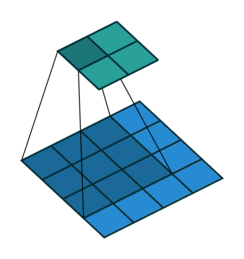

#### Konwolucja z uzupełnieniem i jednostkowym przesunięciem

* uzupełnienie **f** sprawia, że wynik konwolucji ma taki sam rozmiar jak **f** (przy założeniu, że przesunięcie = 1),

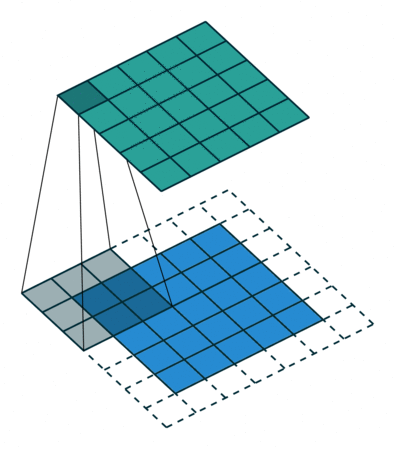

#### Konwolucja bez uzupełnienia z przesunięciem równym 2

* zwiększenie przesunięcia sprawia, że obraz wyjściowy jest odpowiednio mniejszy (tyle razy ile wynosi przesunięcie) od obrazu wejściowego

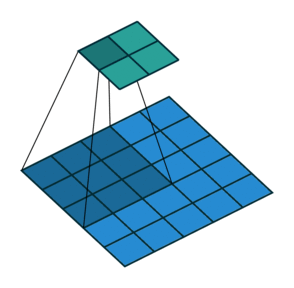

#### Konwolucja bez uzupełnienia, z przesunięciem jednostkowym i rozszerzeniem równym 2

* zastosowanie rozszerzenia bez uzupełnienia sprawia, że **g** będzie częściej wychodziło poza dziedzinę **f**, a więc jeśli nie dodamy uzupełnienia, obraz wyjściowy będzie odpowiednio mniejszy,

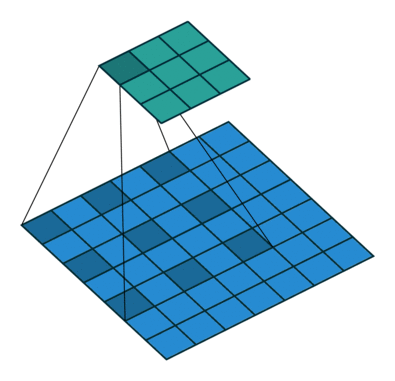

## Przykład

Dla podanych tablic **f** i **g** wykonaj operację konwolucji. Zastosuj uzupełnienie zerami, przesunięcie jednostkowe oraz rozszerzenie równe 1.

$f = [1, 2, 3]$  
$g = [1, 0, 1]$

**1. Uzupełnienie:**

$f = [0, 1, 2, 3, 0]$

**2. Wykonanie konwolucji:**

Konwolucja zostanie wykonana dla $t \in <0, 1, 2>$

$(f \ast g)(0) = 0 * 1 + 1 * 0 + 2 * 1 = 2$  
$(f \ast g)(1) = 1 * 1 + 2 * 0 + 3 * 1 = 4$  
$(f \ast g)(2) = 2 * 1 + 3 * 0 + 0 * 1 = 2$  

$f \ast g = [2, 4, 2]$

Implementacja konwolucji w OpenCV

**UWAGA: w prezentacji została wykorzystana funkcja filter2D, która wykonuje operację konwolucji 2D.**

In [7]:
f = np.array([[1, 2, 3, 4, 5]], np.uint8)
g = np.array([[1, 0, 1, 1, 0]], np.uint8)

def cvconv(f, g):
  # dodanie wypełnienia
  pad_v = (g.shape[0] - 1) // 2
  pad_h = (g.shape[1] - 1) // 2
  fb = cv2.copyMakeBorder(f, pad_v, pad_v, pad_h, pad_h, cv2.BORDER_CONSTANT, 0)

  # konwolucja
  fg_cv = cv2.filter2D(fb.astype(g.dtype), -1, g)

  # usunięcie wypełnienia (opencv tego nie robi automatycznie)
  return fg_cv[pad_v:fb.shape[0] - pad_v, pad_h:fb.shape[1] - pad_h]

# wyświetlenie
h(f)
h(g)
h(cvconv(f, g))

### Zadanie 1

Zaimplementuj funkcję, która dla argumentów **f** i **g** wykona operację konwolucji. Funkcja powinna obsługiwać uzupełnienie oraz wykonywać konwolucję z przesunięciem jednostkowym bez rozszerzenia.

**Uwaga 1: Pamiętaj, aby nie modyfikować f w locie. Prowadzi to do błędnych wyników końcowych.**

**Uwaga 2: Operacja implementacja powinna być dostosowana do danych 2D.**

**Uwaga 3: Możesz wykorzystać część kodu z przykładu powyżej, służącego do dodania wypełnienia.**


In [8]:
def conv(f, g):
  pad_v = (g.shape[0] ) // 2
  pad_h = (g.shape[1] ) // 2

  # dodanie wypełnienia 
  f_padding = np.zeros((f.shape[0] + 2 * pad_v, f.shape[1] + 2 * pad_h), dtype = np.uint8)
  f_padding[pad_v:f.shape[0] + pad_v, pad_h:f.shape[1] + pad_h] = f

  # konwolucja 
  f_conv = [[sum(sum(f_padding[row - pad_v:row - pad_v + g.shape[0], index - pad_h:index - pad_h + g.shape[1]] * g)) for index in range(pad_h, g.shape[1] + pad_h)] for row in range(pad_v, g.shape[0] + pad_v)]
  return f_conv
  

f = np.array([[1, 2, 3, 4, 5]], np.uint8)
g = np.array([[1, 0, 1, 1, 0]], np.uint8)

fg = conv(f, g)

h(f)
h(g)
h(fg)


## Matematyczne zastosowanie konowolucji

### Pochodna

Wprowadźmy pewną funkcję $f(x)$ oraz punkt $x_0$ dla którego otoczenia $f$ jest określona. Pochodną funkcji $f$ możemy zdefiniować jako:

$$f'(x_0) = \lim_{x \rightarrow x_0} \frac{f(x) - f(x_0)}{x - x_0}$$

Innymi słowy, pochodna funkcji określa jak bardzo zmienia się wartość funkcji $f$ w otoczeniu pewnego punktu $x_0$.

W praktyce, posiadając pewną próbkę danych pochodzących z pewnej fukncji, widzimy jedynie zdyskretyzowaną postać tej funkcji. Wówczas, wyrażenie $x \rightarrow x_0$ sprowadza się do najbliższej wartości $x_0$, jaką posiadamy.

Przykład:  
Dla $x = \{0, 1, 2, 3\}$  oraz $f(x) = \{3, 2, 1, 0\}$ możemy policzyć:  
$f'(x_0) = \frac{2 - 3}{1 - 0} = -1$
$f'(x_1) = \frac{1 - 2}{2 - 1} = -1$
$f'(x_2) = \frac{0 - 1}{3 - 2} = -1$

Powyższe dane pochodzą z fukncji $f(x) = -x + 3$, dla której możemy analitycznie wyliczyć pochodną $f'(x) = -1$, co zgadza się z empirycznie wyliczonymi pochodnymi w punktach.

Proste wyliczenie gradientów w praktyce sprowadza się do operacji konwolucji, pomiędzy pewną funkcją $f$ a funkcją $g = [-1, 1]$.



#### Realizacja jako konwolucja

Dla funkcji sinus, pobierzmy z krokiem **0.01** wartości funkcji z przedziału $<0, 4 * \pi>$.

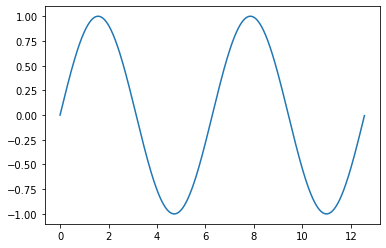

In [9]:
t = np.arange(0.0, 4.0 * np.pi, 0.01)
s = np.sin(t)

plt.plot(t, s)
plt.show()

Następnie wyliczmy iloraz różniczkowy ($\frac{f(x) - f(x_0)}{x - x_0}$) w dwóch krokach:
* za pomocą konwolucji możemy obliczyć różnicę pomiędzy sąsiednimi wartościami ($f(x) - f(x_0)$),
* wyliczając wielkość kroku, dla których wygenerowaliśmy dane (0.01, lub bezpośrednio z argumentów $t[n] - t[n-1]$),

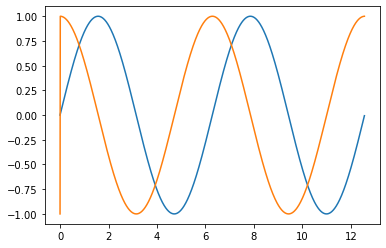

In [10]:
der = np.array([[-1, 1]], np.float32)

s_hat = cvconv(s[np.newaxis], der) / (t[1] - t[0])
s_hat = s_hat[0]

plt.plot(t, s)
plt.plot(t, s_hat)
plt.show()

Powyższa operacja w rezultacie dała nam wykres funkcji $y = \cos(x)$, co jest zgodne z prawdą (analitycznie, pochodna funkcji $\sin$ to $\cos$).

#### Zadanie 2

Korzystając z powyższej implementacji pochodnej znajdź ekstrema podanej poniżej funkcji:

$$y = (x-3)x(x-1)(x-4)(x-7)$$


**Uwaga: ze względu na błędy numeryczne, jako miejsca zerowe uznaj wartości bliskie 0.0. Poprawnym wynikiem będzie wypisanie listy argumentów, dla których pochdna jest bliska zero.**

-2.076000000000157 => 0.32538528134313055
-2.075000000000157 => 0.3253852558300782
0.4789999999995618 => -0.019934616755710437
0.47999999999956167 => -0.01993490104319991
0.48099999999956156 => -0.019935021362062585
0.48199999999956145 => -0.019934977784233622
0.48299999999956134 => -0.019934770381806483
0.4839999999995612 => -0.019934399227032776
2.8089999999993047 => 0.1473401490502638
2.809999999999305 => 0.14734045665009987
2.8109999999993054 => 0.14734058381196602
2.811999999999305 => 0.14734053042072892
2.8129999999993043 => 0.14734029636137652
2.8139999999993046 => 0.1473398815190182
5.982999999998956 => -0.5401009694584787
5.9839999999989555 => -0.5401006967367933


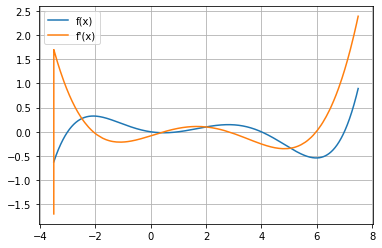

In [11]:
x = np.arange(-3.5, 7.5, 0.001)
y = 0.001 * (x+3)*x*(x-1)*(x-4)*(x-7)

y_hat = cvconv(y[np.newaxis], np.array([[-1, 1]], np.float32))[0] / (x[1] - x[0])

zeros = np.where(np.abs(y_hat) < 0.0005)[0]

for elem in zeros:
  print(x[elem], '=>', y[elem])

plt.plot(x, y, label='f(x)')
plt.plot(x, y_hat, label="f'(x)")
plt.grid()
plt.legend()
plt.show()

### Pochodna 2D

Na poprzednich zajęciach określiliśmy obrazy jako funkcje 2-wymiarowe. Oznacza to, że dla nich również możemy policzyć pochodne.

Pochodna dla obrazów 2D ma ważną własność: dla zmian wartości funkcji (obrazu), a więc dla miejsc, gdzie intensywność pikseli jest różna, pochodna zwróci różną od zera wartość.



Zdefiniujmy sobie prosty obraz, pokazany poniżej.

In [12]:
s = np.array([
  [0, 0, 0, 0, 0, 0, 0, 0],
  [0, 1, 1, 1, 0, 0, 0, 0],
  [0, 1, 1, 1, 1, 1, 0, 0],
  [0, 1, 1, 1, 1, 1, 0, 0],
  [0, 1, 1, 1, 1, 1, 0, 0],
  [0, 1, 1, 1, 1, 1, 0, 0],
  [0, 1, 1, 1, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0]
], np.float32)

h_color_3d(s)

Wówczas, możemy zdefinować dwie funkcje obliczające pochodną, odpowiednio dla danych horyzontalnych, wertykalnych:

In [13]:
der_h = np.array([[-1, 1]], np.float32)
der_v = np.array([[-1], [1]], np.float32)

h_color_3d(cvconv(s, der_h) / (t[1] - t[0]))
h_color_3d(cvconv(s, der_v) / (t[1] - t[0]))

### Pochodna 2-go rzędu

Zdefiniujmy sobie obraz, którego krawędzie nie są aż tak widoczne.

Aby lepiej wykrywać obszary w których załamanie się intensywności koloru jest większa, można znaleźć obszary w których pochodna 1-ego rzędu szybko narasta/maleje. W tych miejscach znajdują się krawędzie obiektów na obrazie.

Aby wyliczyć takie miejsca, możemy policzyć pochodną obliczonej pochodnej, a więc pochodną 2-go rzędu. 

Przypomnijmy wzór na pochodną:

$$f'(x_0) = \lim_{x \rightarrow x_0} \frac{f(x) - f(x_0)}{x - x_0}$$

Obrazy są funkcjami z argumentami zmieniającymi się jednostkowo (np. piksel o pozycji (0,0), (0,1), (0,...). Oznacza to, że $x - x_0 = 1$. Dla uproszczenia wprowadźmy $x_0$ jako piksel ''0'', $x_1$ jako piksel ''1'', itp. Możemy więc zapisać pochodną dla obrazu jako:

$$f'(x_0) = \frac{f(x_1) - f(x_0)}{x_1 - x_0} = f(x_1) - f(x_0)$$

(omijamy $\lim_{x \rightarrow x_0}$ ponieważ wiemy jaką dokładnie wartość przyjmuje $x$)

Wówczas, pochodna 2-go stopnia przyjmuje postać:

$$f''(x_0) = (f(x_1) - f(x_0))'$$
$$f''(x_0) = f'(x_1) - f'(x_0)$$
$$f''(x_0) = f(x_2) - f(x_1) - f(x_1) + f(x_0)$$
$$f''(x_0) = f(x_2) -2 f(x_1) + f(x_0)$$

Powyższy wzór możemy zrealizować stosując konwolucję z funkcją $g=[1, -2, 1]$.

In [14]:
s = np.array([
  [0, 0, 0, 0, 0, 0, 0, 0],
  [0, 1, 1, .8, .5, .1, 0, 0],
  [0, 1, 1, .8, .6, .2, 0, 0],
  [0, 1, 1, 1, .7, .3, .05, 0],
  [0, 1, 1, 1, .7, .3, .05, 0],
  [0, 1, 1, 1, .5, .3, 0, 0],
  [0, 1, 1, 1, .3, .1, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0]
], np.float32)

der_h = np.array([
  [1, -2, 1]
], np.float32)
der_v = np.array([
  [1], 
  [-2], 
  [1]
], np.float32)

h_color_3d(s)
h_color_3d(cvconv(s, der_h))
h_color_3d(cvconv(s, der_v))

Wykonując pochodną 2-go rzędu horyzontalnie korzystamy z funkcji $g = [[-1, 2, -1]]$, która ma rozmiar (1, 3). Równoznaczną jej operacją jest konwolucja z funkcją:

$$g_h = \begin{bmatrix}
0 & 0 & 0\\
-1 & 2 & -1\\
0 & 0 & 0\\
\end{bmatrix}$$

Analogicznie dla pochodnej 2-go rzędu wertykalnie:

$$g_v = \begin{bmatrix}
0 & -1 & 0\\
0 & 2 & 0\\
0 & -1 & 0\\
\end{bmatrix}$$

Obie funkcje możemy złożyć za pomocą operacji dodawania otrzymując funkcję:

$$g = \begin{bmatrix}
0 & -1 & 0\\
-1 & 4 & -1\\
0 & -1 & 0\\
\end{bmatrix}$$

Jest to tak zwany operator **Laplasjan**, który może być wykorzystany do wykrywania krawędzi wertykalnie i horyzontalnie jednocześnie.

**Uwaga: stosuje się również formę:**

$$g = \begin{bmatrix}
0 & 1 & 0\\
1 & -4 & 1\\
0 & 1 & 0\\
\end{bmatrix}$$

**która realizuje to samo zadanie.**

In [15]:
der = np.array([
  [0, -1, 0],
  [-1, 4, -1],
  [0, -1, 0]
], np.float32)

h_color_3d(cvconv(s, der))
h_color_3d(np.abs(cvconv(s, der)))

## Znane operacje splotowe

Biblioteka OpenCV zawiera gotowe implementacje wielu operacji splotowych. Do najpopularniejszych należą:
* blur (rozmycie na podstawie średniej z sąsiednich pikseli),
* gaussian blur (rozmycie na podstaiw sumy ważonej pikseli zgodnie z rozkładem gaussa),
* laplacian,
* sobel (detekcja krawędzi),
* median filter,
* bilateral

Poniżej zostały zaprezentowane wyniki działania ich implementacji w OpenCV.

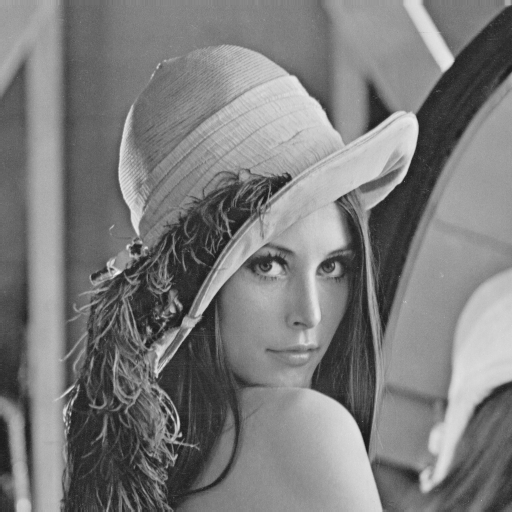

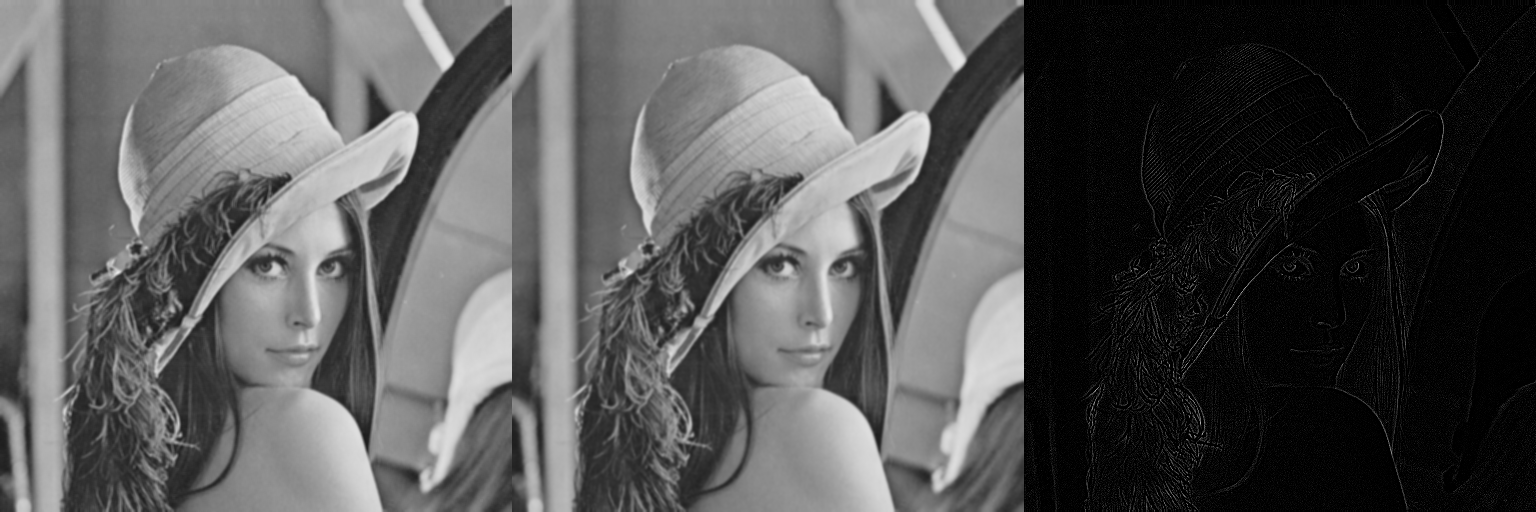

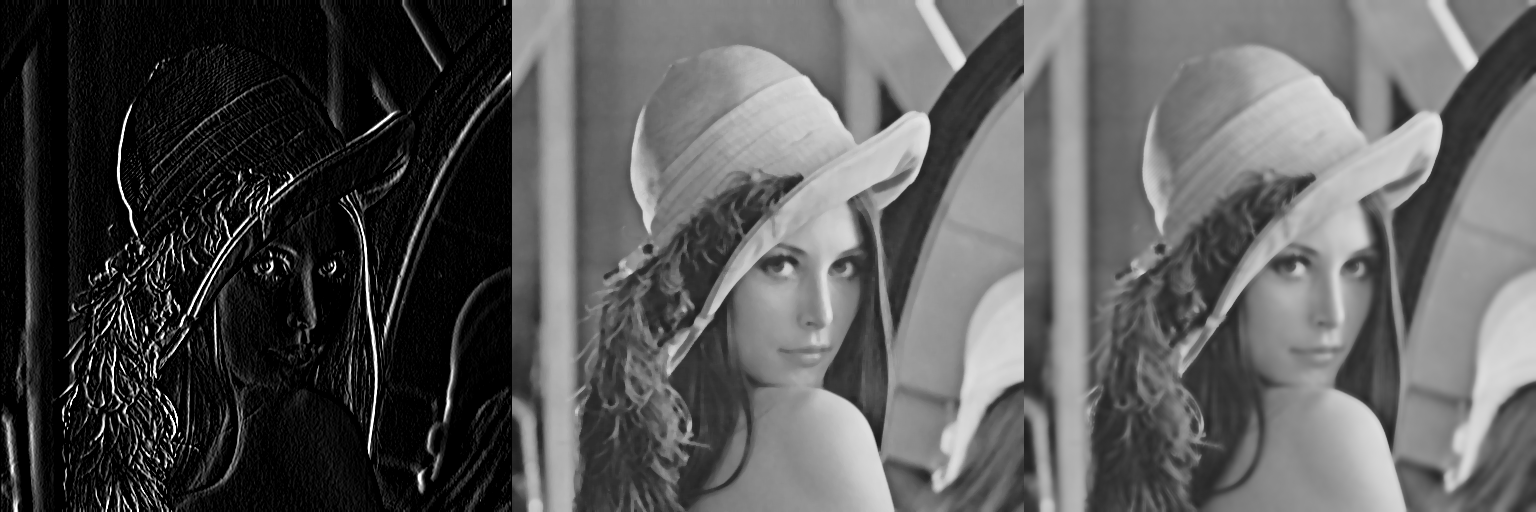

In [16]:
img = cv2.imread('./lena_std.tif', 1)
img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

imshow(img_grayscale)

img_blur = cv2.blur(img_grayscale, (3, 3))
img_gaussian_blur = cv2.GaussianBlur(img_grayscale, (5, 5), 0)
img_laplacian = cv2.Laplacian(img_grayscale, cv2.CV_32F)
img_sobel = cv2.Sobel(img_grayscale, cv2.CV_64F, 1, 0, ksize=3)
img_median = cv2.medianBlur(img_grayscale, 5)
img_bilateral = cv2.bilateralFilter(img_grayscale, 9, 75, 75)

imshow(np.concatenate([img_blur, img_gaussian_blur, img_laplacian], 1))
imshow(np.concatenate([img_sobel, img_median, img_bilateral], 1))

### Zadanie 3

Przygotuj funkcje $g_1$ oraz $g_2$ odpowiednio dla operacji **blur** oraz **gaussian blur**.

Wykonaj operację konwolucji z tymi funkcjami na obrazie ''Lenna'' w formacie RGB.

**Uwaga: przygotowanie funkcji $g_1$ oraz $g_2$ powinno opierać się jedynie na pytnonie i numpy.**

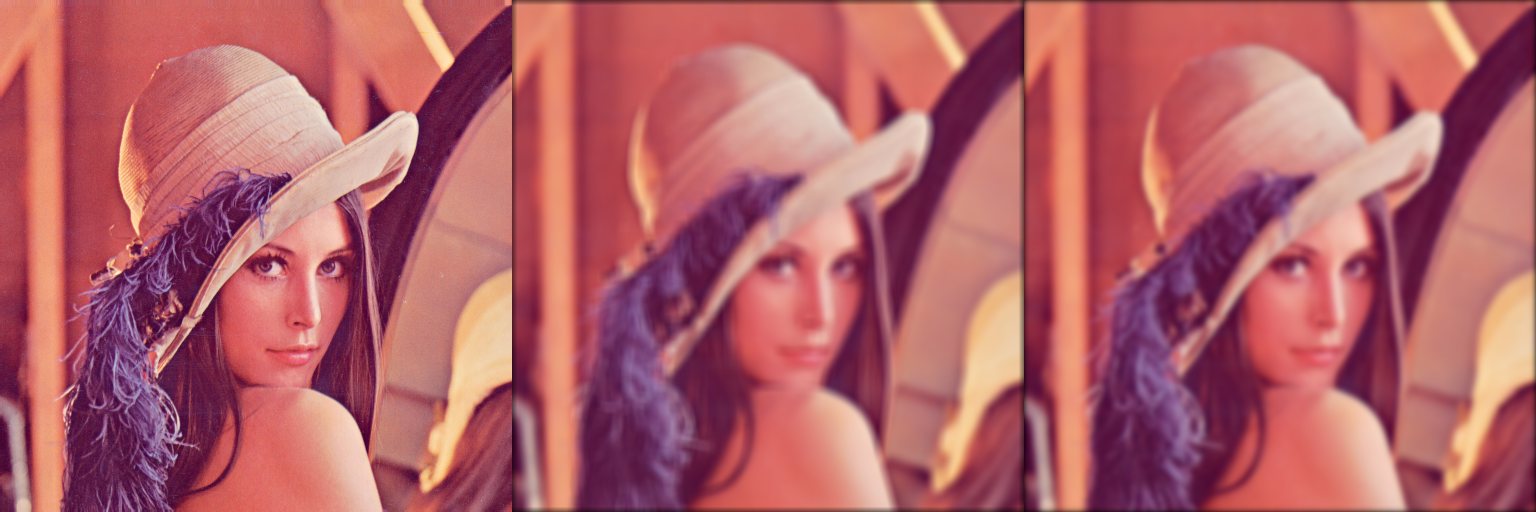

In [17]:
def blur_kernel(size):
  return np.ones((size, size)) / (size * size)


def gaussian_kernel(size, sig=3.0):
  ax = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)
  xx, yy = np.meshgrid(ax, ax)
  kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))
  return kernel / np.sum(kernel)


g1 = blur_kernel(11)
g2 = gaussian_kernel(21)

img_g1 = cvconv(img, g1)
img_g1 = img_g1.astype(np.uint8)

img_g2 = cvconv(img, g2)
img_g2 = rescale_intensity(img_g2) * 255.0
img_g2 = img_g2.astype(np.uint8)

imshow(np.concatenate([img, img_g1, img_g2], 1))

## Wykrywanie krawędzi

Praktycznym wykorzystaniem Laplasjana jest wykrywanie krawędzi. Definiując funkcję $g$ jako:

$$g = \begin{bmatrix}
0 & -1 & 0\\
-1 & 4 & -1\\
0 & -1 & 0\\
\end{bmatrix}$$

oraz stosując konwolucję na obrazie w przestrzeni barw **grayscale** możemy wykonać proste wykrywanie krawędzi.

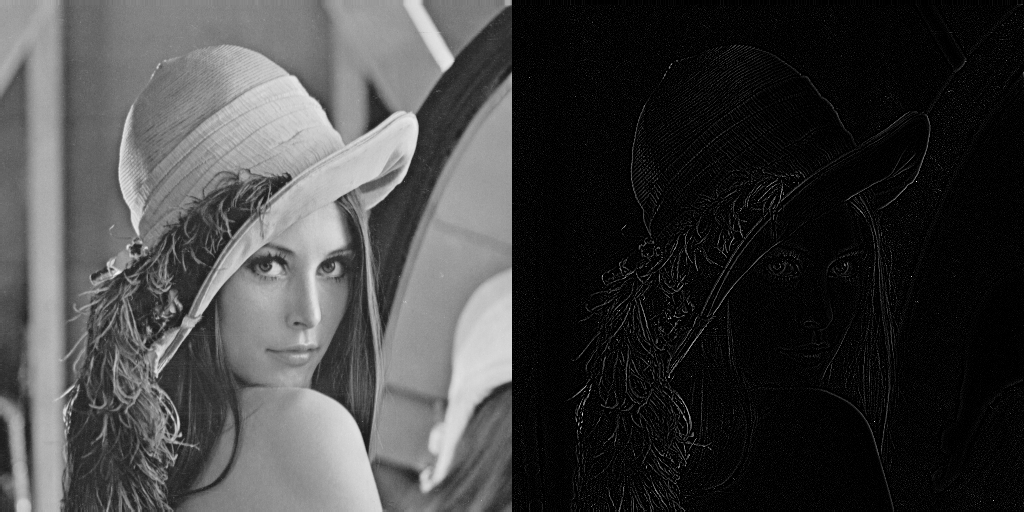

In [18]:
g = np.array([
  [0, -1, 0],
  [-1, 4, -1],
  [0, -1, 0]
], np.float32)

img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) / 255.0

img_edges = cv2.filter2D(img_grayscale, -1, g)
imshow(np.concatenate([img_grayscale, img_edges], 1) * 255.0)

Wiedząc, że Laplasjan zwraca wartości bliskie zeru dla pikseli wokół których nie następuje duża zmiana intensywności i wartości skrajne dla obszarów ze zmianą intensywności piksela (zarówno wartości ujemne jak i dodatnie) możemy pobrać wartości absolutne wyniku, w ten sposób znajdując krawędzie.

Wynik tej operacji został zaprezentowany poniżej.

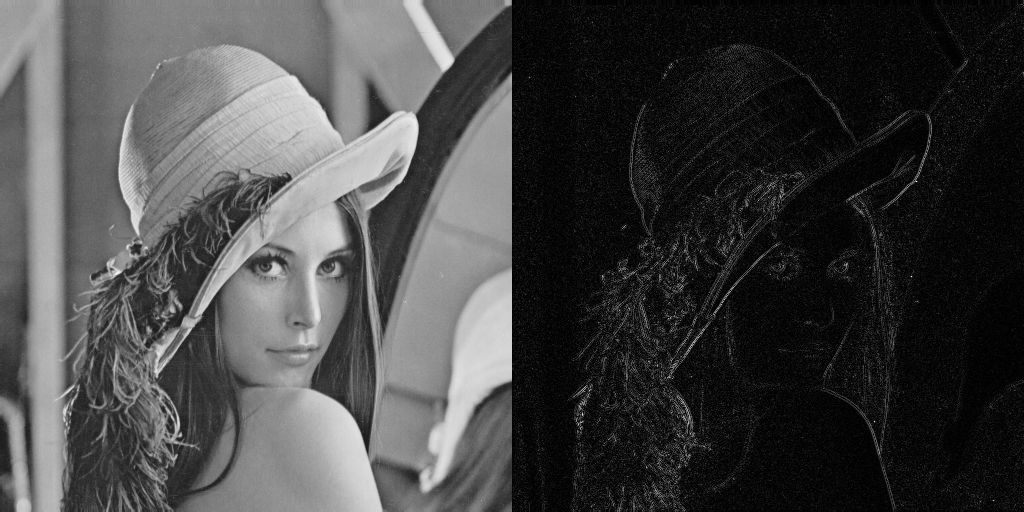

In [19]:

img_edges = np.abs(img_edges)
img_edges = rescale_intensity(img_edges)

imshow(np.concatenate([img_grayscale, img_edges], 1) * 255.0)

**Uwaga:**  
pochodna 2-go rzędu z definicji zwraca wartości skrajne dla obszarów o dużej zmienności intensywności. Taka cecha charakteryzuje nie tylko krawędzie ale również obszary o wysokiej ostrości.

### Zadanie 4

**Ant challenge** to problem dotyczący rekonstrukcji obrazu z wielu pośrednich obrazów, zawierających istotne dla wyniku szczegóły. Dane zawierają zdjęcia mrówki (w relatywnie tej samej pozie) z ostrością ustawioną na różnej odległości od obiektywu.

Zadanie polega na zaproponowaniu algorytmu rekonstrukcji obrazu, który będzie zawierał obszary o największej ostrości z poszczególnych klatek.

Wskazówki:
* wypełnij jedynie zawartość funkcji **detect_prec** oraz **merge**,
* funkcja **detect_prec** powinna pobierać pojedynczy obraz mrówki w formacie RGB i zwracać maskę z zakresu $<0, 1>$, na której obszary o dużej ostrości będą miały wartości bliskie 1,
* funkcja **merge** powinna pobierać listę obrazów mrówki oraz odpowiadające im rezultaty funkcji **detect_prec**. Funkcja powinna dla każdego pisela wynikowego wykonać **sumę ważną pikseli z listy obrazów mrówki**, gdzie wagami powinny być rezultaty funkcji **detect_prec**,
* dla uwydatnienia rezultatów można skorzystać z korekcji gamma wykonanej na rezultacie funkcji **detect_prec**.


===
Zdjęcia mrówki z ostrością na rożnej odległości



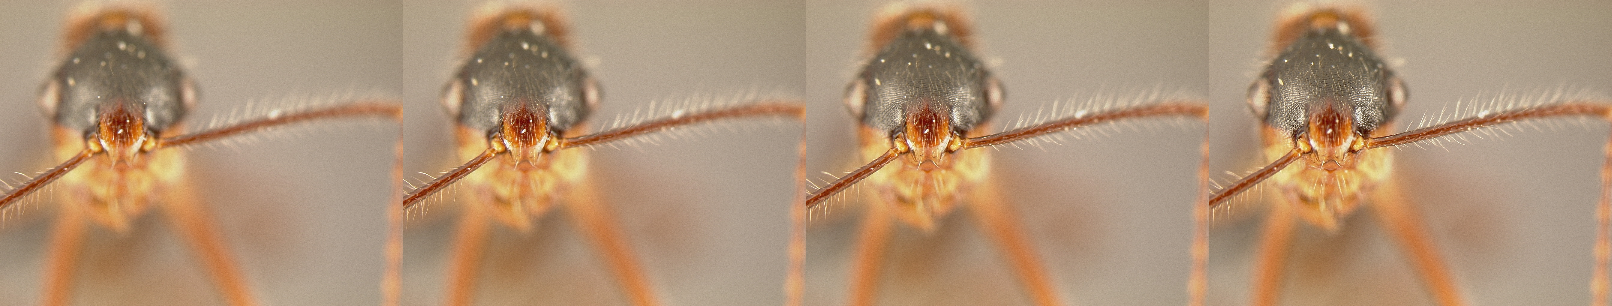

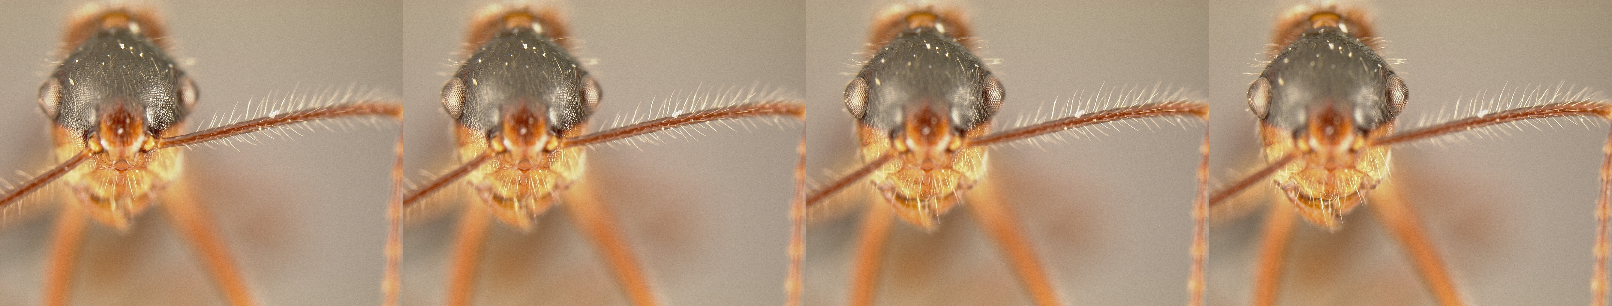

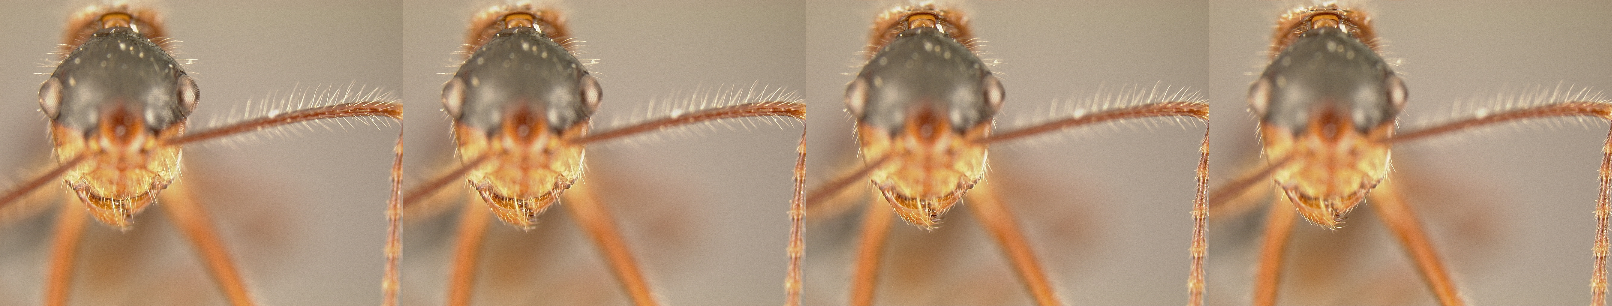

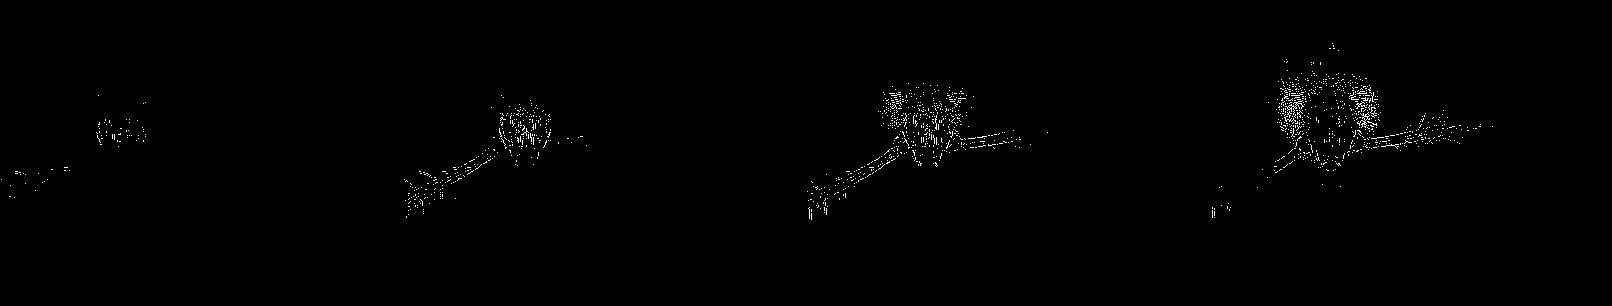

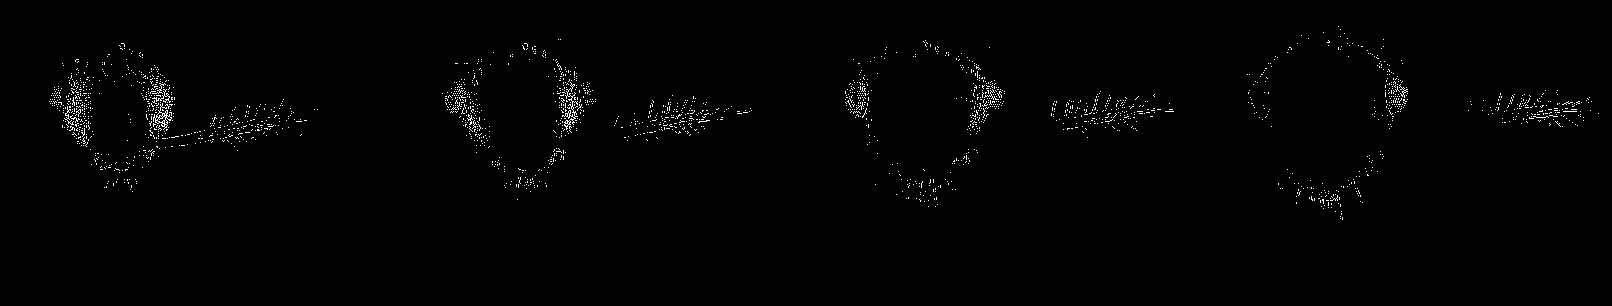

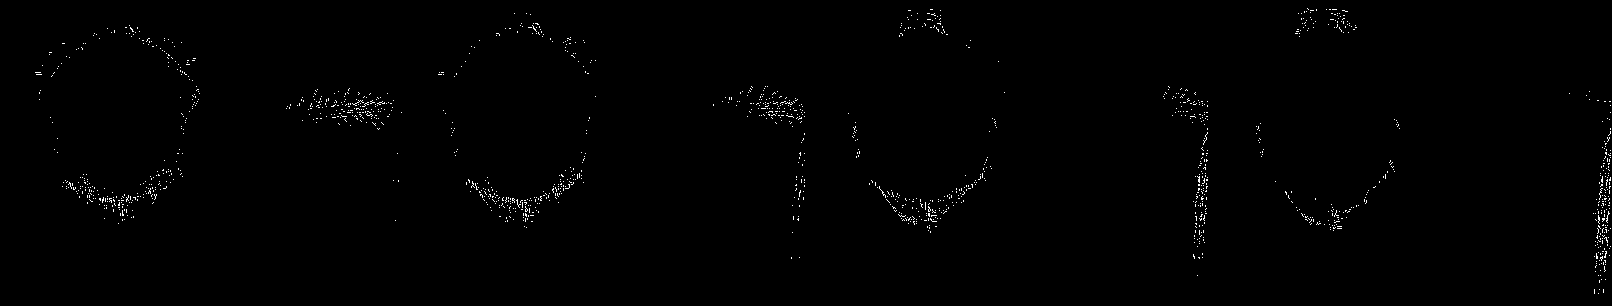


===
Zwykłe uśrednienie obrazów składowych oraz docelowy obraz



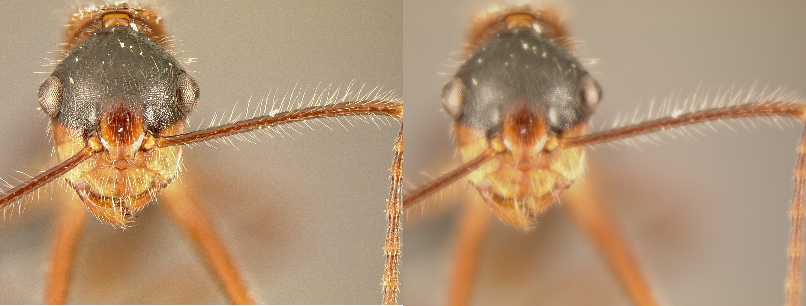


===
Wynik rekonstrukcji obrazu na podstawie detekcji obszarów z wysoką ostrością



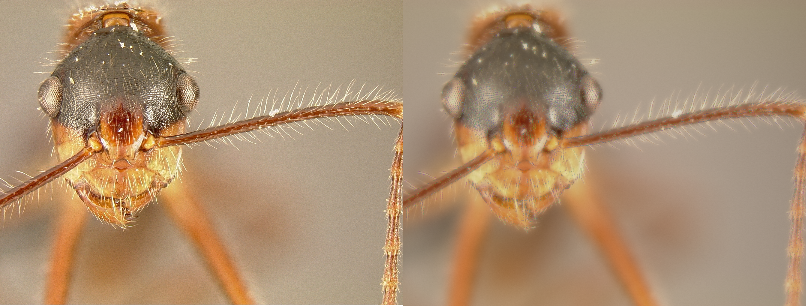

In [20]:
files = [
    './bug/b_bigbug0000_croppped.png',
    './bug/b_bigbug0001_croppped.png',
    './bug/b_bigbug0002_croppped.png',
    './bug/b_bigbug0003_croppped.png',
    './bug/b_bigbug0004_croppped.png',
    './bug/b_bigbug0005_croppped.png',
    './bug/b_bigbug0006_croppped.png',
    './bug/b_bigbug0007_croppped.png',
    './bug/b_bigbug0008_croppped.png',
    './bug/b_bigbug0009_croppped.png',
    './bug/b_bigbug0010_croppped.png',
    './bug/b_bigbug0011_croppped.png',
    './bug/b_bigbug0012_croppped.png',
]

def detect_prec(img):
  result = np.zeros((img.shape[0], img.shape[1]))
  for index, row in enumerate(img):
    for index_2, pixel in enumerate(row):
      if index > 0 and index < img.shape[0] - 1 and index_2 > 0 and index_2 < img.shape[1] - 1:
        avg_r = sum([img[index][index_2 - 1][0], img[index][index_2 + 1][0], img[index - 1][index_2 - 1][0], img[index - 1][index_2 + 1][0], img[index + 1][index_2 - 1][0], img[index + 1][index_2 + 1][0], img[index - 1][index_2][0], img[index + 1][index_2][0] ]) / 8
        avg_g = sum([img[index][index_2 - 1][1], img[index][index_2 + 1][1], img[index - 1][index_2 - 1][1], img[index - 1][index_2 + 1][1], img[index + 1][index_2 - 1][1], img[index + 1][index_2 + 1][1], img[index - 1][index_2][1], img[index + 1][index_2][1] ]) / 8
        avg_b = sum([img[index][index_2 - 1][2], img[index][index_2 + 1][2], img[index - 1][index_2 - 1][2], img[index - 1][index_2 + 1][2], img[index + 1][index_2 - 1][2], img[index + 1][index_2 + 1][2], img[index - 1][index_2][2], img[index + 1][index_2][2] ]) / 8
        result[index][index_2] = 1 if (avg_r - pixel[0]) / 255 + (avg_g - pixel[1]) / 255 + (avg_b - pixel[2]) / 255 >= 0.3 else 0
  return result 

def merge(bugs, bugs_prec):
  result = np.zeros((bugs[0].shape[0], bugs[0].shape[1], 3))

  for index in range(bugs[0].shape[0]):
    for index_2 in range(bugs[0].shape[1]):
      counter = 1
      for i in range(len(bugs)):
        if bugs_prec[i][index][index_2] != 0:
          result[index][index_2] += 4 * counter * bugs[i][index][index_2] * bugs_prec[i][index][index_2]
          counter += 1
        else:
          result[index][index_2] += counter * bugs[i][index][index_2] * 0.95
          if counter > 1:
            counter -= 1
      result[index][index_2] = result[index][index_2] / len(bugs)
  return result

# wczytanie danych
bugs = [cv2.imread(f, 1) for f in files]
bugs = list(map(lambda i: cv2.resize(i, None, fx=0.3, fy=0.3), bugs))
bugs_prec = list(map(detect_prec, bugs))

# wczytanie spodziewanego wyniku algorytmu
result = cv2.imread('./bug/result.png', 1)
result = cv2.resize(result, None, fx=0.3, fy=0.3)

print('\n===')
print('Zdjęcia mrówki z ostrością na rożnej odległości\n')
imshow(np.concatenate(bugs[0:4], 1))
imshow(np.concatenate(bugs[4:8], 1))
imshow(np.concatenate(bugs[8:12], 1))

imshow((np.concatenate(bugs_prec[0:4], 1) * 255).astype(np.uint8))
imshow((np.concatenate(bugs_prec[4:8], 1) * 255).astype(np.uint8))
imshow((np.concatenate(bugs_prec[8:12], 1) * 255).astype(np.uint8))

bug_combined = merge(bugs, bugs_prec)
bug = np.stack(bugs, 0).mean(0)

print('\n===')
print('Zwykłe uśrednienie obrazów składowych oraz docelowy obraz\n')
imshow(np.concatenate([result, bug], 1))

print('\n===')
print('Wynik rekonstrukcji obrazu na podstawie detekcji obszarów z wysoką ostrością\n')
imshow(np.concatenate([result, bug_combined], 1))